In [1]:
# geo_env_gdal env

from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import os 



# Data collection

## Windspeed
- windspeed average in Gtiff format from https://globalwindatlas.info/en  

## Roughness

- world landcover from in nc format from http://maps.elie.ucl.ac.be/CCI/viewer/download.php
- extraction of AURA region and Gtif format thank to the command (see function below) :
- gdalwarp -of Gtiff -co COMPRESS=LZW -co TILED=YES -ot Byte -te -180.0000000 -90.0000000 180.0000000 90.0000000 -tr 0.002777777777778 0.002777777777778 -t_srs EPSG:4326 NETCDF:C3S-LC-L4-LCCS-Map-300m-P1Y-Year-v2.1.1.nc:BandName OutputFilename.tif 
- remaping to roughness length data thanks to table https://wes.copernicus.org/articles/6/1379/2021/wes-6-1379-2021-t07.xlsx (see fonction below)



# Open and display Geotiff windspeed with gdal

In [2]:
def open_plot_tiff(path_tif):
    ds = gdal.Open(path_tif)
    array = ds.GetRasterBand(1).ReadAsArray()
    plt.imshow(array)
    plt.colorbar()
    print(ds.GetGeoTransform())
    print(ds.GetProjection())
    return ds

/home/vlechappe/anaconda3/envs/geo_env_gdal/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


(2.0615726821936846, 0.002500000000000124, 0.0, 46.80576874773548, 0.0, -0.002500000000000124)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


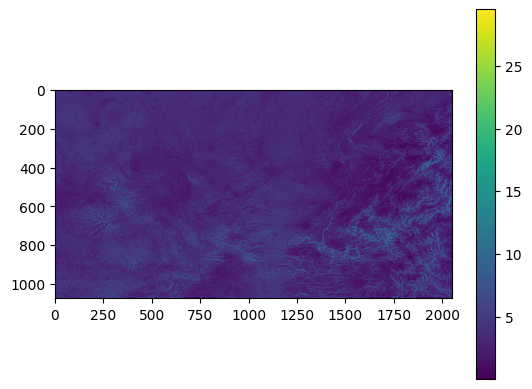

In [3]:
path_windspeed_tif = "./data_tiff/windspeed/windspeed_AURA_10m.tif"
ds_windspeed = open_plot_tiff(path_windspeed_tif)

# Open and display Geotiff landcover (LC) with gdal

In [4]:
# This function extract information of landcover of the desired area defined by "bounds" from .nc file to .tif file
def extract_LC_Gtiff(path_input_nc, path_output_Gtiff, xRes, yRes, bounds):
    try:
        os.remove(path_output_Gtiff)
    except FileNotFoundError:
        print("no file "+path_output_Gtiff+" to delete")
    command = "gdalwarp -of Gtiff -co COMPRESS=LZW -co TILED=YES -ot Byte -te "+str(bounds[0])+" "+str(bounds[1])+" "+str(bounds[2])+" "+str(bounds[3])+" -tr "+str(xRes)+" "+str(yRes)+" -t_srs EPSG:4326 NETCDF:"+path_input_nc+":lccs_class "+path_output_Gtiff
    print(command)
    os.system(command)


In [5]:
# This function compute the coordinate ot Bottom Right Corner (BRC) from the information of the Top Left Corner (TLC)
# from the resolutions and the pixel numbers
def convert_res_size(xTLC, yTLC, xRes, yRes, height, width):
    xBRC = xTLC+xRes*width # x position Bottom Right Corner 
    yBRC = yTLC-yRes*height # y position Bottom Right Corner
    return xBRC, yBRC

In [6]:
xRes = 0.003 # degree smallest resolution  http://maps.elie.ucl.ac.be/CCI/viewer/download.php
yRes = 0.003 # degree smallest resolution 
xTLC = 2 # x position top left corner
yTLC = 46.9 # y position top left corner

# pixel number
#width = 10   # xres = 0.2 
#height = 10  # yres = 0.1 

width = 1750  # xres = 0.003  ok pour crop tout la region rhone Alpes
height = 950  # yres = 0.003 


xBRC, yBRC = convert_res_size(xTLC = xTLC, yTLC = yTLC, xRes = xRes, yRes = yRes, height = height, width =width)
bounds = (xTLC, yBRC, xBRC, yTLC) 
print(bounds)
#bounds = (2, 44, 7.2, 46.9) # AURA region large

path_input_nc = "./data_tiff/copernicus_roughness/LC_2020.nc"
path_LC_tif = "./data_tiff/copernicus_roughness/LC_AURA.tif"
extract_LC_Gtiff(path_input_nc = path_input_nc, path_output_Gtiff = path_LC_tif, xRes = xRes, yRes = yRes, bounds = bounds)
#ds_LC = open_plot_tiff(path_LC_tif)


(2, 44.05, 7.25, 46.9)
gdalwarp -of Gtiff -co COMPRESS=LZW -co TILED=YES -ot Byte -te 2 44.05 7.25 46.9 -tr 0.003 0.003 -t_srs EPSG:4326 NETCDF:./data_tiff/copernicus_roughness/LC_2020.nc:lccs_class ./data_tiff/copernicus_roughness/LC_AURA.tif
Creating output file that is 1750P x 950L.
Processing NETCDF:./data_tiff/copernicus_roughness/LC_2020.nc:lccs_class [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


# Projection function from LC data  to roughness length data using conversion informaton in csv file

In [7]:
# This function computes the roughness value from the conversion table composed of LC list and roughness list 
def LC_to_roughness_proj(LC_value, LC_list, roughness_list):
    try:
        i = LC_list.index(LC_value) 
        roughness_value = roughness_list[i] 
    except ValueError:
        print("The LC value",LC_value,"does not exists") 
        roughness_value = -1
    return roughness_value

pd_data = pd.read_csv("./data_tiff/copernicus_roughness/LC_to_roughness.csv", sep = ",") 
LC_list = pd_data["LC"].to_list()
roughness_list = pd_data["roughness"].to_list()


# The lists are extraced from .csv file. The file is not opened in the functions otherwise it takes too much time
#roughness = LC_to_roughness_proj(200, LC_list, roughness_list)
#print(roughness)

# Reproject landcover to get roughness lenght and save as a new Geotiff image

In [8]:
# This function converts the .tif image of landcover to .tif image of roughness length using the aboe function (LC_to_roughness_proj)
def LC_to_roughness_tiff(path_LC_tif, path_roughness_tif, LC_list, roughness_list):
        ds_LC = gdal.Open(path_LC_tif)
        # Lire les informations sur le raster
        geotransform = ds_LC.GetGeoTransform()
        projection = ds_LC.GetProjection()
        nb_bandes = ds_LC.RasterCount
        band = ds_LC.GetRasterBand(1)    
        xsize = band.XSize
        ysize = band.YSize
        array = band.ReadAsArray()
        newarray = array.astype('f') # need to transfor data type form in to float
        #print(type(array))# numpy array
        #print(array.dtype) # int, float, ....
        #print(newarray.dtype) # int, float, ....
        band = None #close it

        for i in range(0,ysize):#ysize
                for j in range(0,xsize): #xsize
                        newarray[i,j] = LC_to_roughness_proj(array[i,j],LC_list, roughness_list)
                        #print(array[i,j])
        
        driver = gdal.GetDriverByName('GTiff')
        ds_roughness = driver.Create(path_roughness_tif, xsize, ysize, 1, gdal.GDT_Float32)
        #new_tiff = driver.Create(output_tiff_path,xsize,ysize,1,gdal.GDT_Int16)
        ds_roughness.SetGeoTransform(geotransform)
        ds_roughness.SetProjection(projection)
        #new_tiff.GetRasterBand(1).WriteArray(np_array)
        ds_roughness.GetRasterBand(1).WriteArray(newarray)

        ds_roughness.FlushCache() #Saves to disk 
        ds_roughness = None #closes the file

path_roughness_tif = "./data_tiff/copernicus_roughness/roughness_AURA.tif"
LC_to_roughness_tiff(path_LC_tif, path_roughness_tif, LC_list, roughness_list) # execute just once, it takes 36 s


# Open and display Geotiff roughness with gdal

(2.0, 0.003, 0.0, 46.9, 0.0, -0.003)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


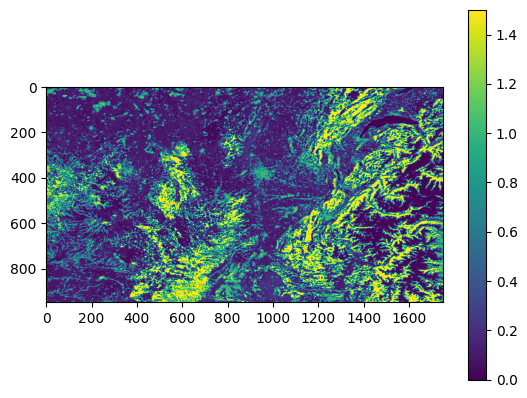

In [9]:
ds_roughness = open_plot_tiff(path_roughness_tif)


# Resample, resize Gtiff windspeed

In [10]:
# This function resize a .tiff image to the desired "bounds" and resample it with the desired resolution
def resize_res_tiff(path_input, path_output, xRes, yRes, bounds):
    try:
        os.remove(path_output)
    except FileNotFoundError:
        print("no file "+path_output+" to delete")
    command = "gdalwarp -tr "+str(xRes)+" "+str(yRes)+" -te "+str(bounds[0])+" "+str(bounds[1])+" "+str(bounds[2])+" "+str(bounds[3])+" "+path_input+" "+path_output
    os.system(command)


In [11]:
path_windspeed_resize_tif = "./data_tiff/windspeed/windspeed_AURA_10m_resize.tif"
resize_res_tiff(path_input = path_windspeed_tif, path_output = path_windspeed_resize_tif, xRes = xRes, yRes = yRes, bounds = bounds)


# pas besoin de resize pour roughness car le mieux est d'extraire directement au depart avec la bonne resolution et la bonne taille
#path_roughness_resize_tif = "./data_tiff/copernicus_roughness/roughness_AURA_resize.tif"
#resize_res_tiff(path_input = path_roughness_tif, path_output = path_roughness_resize_tif, xRes = xRes, yRes = yRes, bounds = bounds)


# print(ds_windspeed_new.GetGeoTransform())
# #print(ds_windspeed_new.GetProjection())
# print(ds_roughness_new.GetGeoTransform())

no file ./data_tiff/windspeed/windspeed_AURA_10m_resize.tif to delete
Creating output file that is 1750P x 950L.
Processing ./data_tiff/windspeed/windspeed_AURA_10m.tif [1/1] : 0Using internal nodata values (e.g. -999) for image ./data_tiff/windspeed/windspeed_AURA_10m.tif.
Copying nodata values from source ./data_tiff/windspeed/windspeed_AURA_10m.tif to destination ./data_tiff/windspeed/windspeed_AURA_10m_resize.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


# Generate the new Geotiff image from windspeed and roughness

In [45]:
# This functions computes the optimal height for one pixel of value Vr, z0 using the data from pd_data_h_opt

def compute_optimal_height(Vr, z0, pd_data_h_opt, Vr_list):
    if z0==0:
        h_opt = 12
    else:
        if Vr<2.5:
            h_opt = 30
        elif Vr>8:
            h_opt = 12
        else:
            z0_list = pd_data_h_opt["z="+str(z0)].to_list()
            index_Vr_close = min(range(len(Vr_list)), key=lambda i: abs(Vr_list[i]-Vr))
            h_opt = z0_list[index_Vr_close]
    return h_opt


#roughness_list = [0.003, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.6, 0.8, 1, 1.2, 1.5]
# Open and read the csv file  
pd_data_h_opt = pd.read_csv("./data_tiff/optimal_height/h_opt_map.csv", sep = ",") 
Vr_list = pd_data_h_opt["Vr"].to_list()  # vref a 10m
#print(Vr_list)
h_opt = compute_optimal_height(3, 0.01, pd_data_h_opt, Vr_list)
print(h_opt)

23.12562814070352


In [46]:
# This functions generates a new .tif image from windspeed and roughness tif images
def compute_new_image(path_windspeed_tif, path_roughness_tif, path_new_tif, pd_data_h_opt):
        ds_windspeed = gdal.Open(path_windspeed_tif)
        ds_roughness = gdal.Open(path_roughness_tif)
        # Lire les informations sur le raster
        geotransform = ds_windspeed.GetGeoTransform()
        projection = ds_windspeed.GetProjection()
        nb_bandes = ds_windspeed.RasterCount
        band_windspeed = ds_windspeed.GetRasterBand(1)
        band_roughness = ds_roughness.GetRasterBand(1)     
        xsize = band_windspeed.XSize
        ysize = band_windspeed.YSize
        array_windspeed = band_windspeed.ReadAsArray()
        array_roughness = band_roughness.ReadAsArray()
        #print(type(array))# numpy array
        #print(array_windspeed.dtype) # float 32
        #print(array_roughness.dtype) # float 32
        band_windspeed = None #close it
        band_roughness = None #close it
        array_new = np.empty(np.shape(array_windspeed), dtype="float32")
        #print(array_new.dtype)
        #print(np.shape(array_windspeed))
        #print(np.shape(array_new))
        for i in range(0,ysize):#ysize
                for j in range(0,xsize): #xsize
                        #array_new[i,j] = array_windspeed[i][j]+array_roughness[i][j]
                        array_new[i,j] = compute_optimal_height(array_windspeed[i][j], array_roughness[i][j], pd_data_h_opt, Vr_list)
                        #print(array_new[i,j])
        
        driver = gdal.GetDriverByName('GTiff')
        ds_new = driver.Create(path_new_tif, xsize, ysize, 1, gdal.GDT_Float32)
        #new_tiff = driver.Create(output_tiff_path,xsize,ysize,1,gdal.GDT_Int16)
        ds_new.SetGeoTransform(geotransform)
        ds_new.SetProjection(projection)
        #new_tiff.GetRasterBand(1).WriteArray(np_array)
        ds_new.GetRasterBand(1).WriteArray(array_new)
        ds_new.FlushCache() #Saves to disk 
        ds_new = None #closes the file

path_new_tif = "./data_tiff/optimal_height/optimal_height.tif"
compute_new_image(path_windspeed_resize_tif, path_roughness_tif, path_new_tif, pd_data_h_opt)


# 6.30 min puis 14.27 min

# Crop the Gtiff images to the AURA region

In [47]:
# This function generate a new .tif image from the crop of .tif image and a shape file 
# The image contains 2 bands : the second one is only 0 or 255 if inside or outside the croppe zone 
def crop_tiff(path_input, path_output, path_shape):
    try:
        os.remove(path_output)
    except FileNotFoundError:
        print("no file "+path_output+" to delete")
    command = "gdalwarp -cutline "+path_shape+" -dstalpha "+path_input+" "+path_output
    os.system(command)


In [48]:
path_shape = "./data_tiff/AURA.geojson"
path_windspeed_cropped_tif = "./data_tiff/windspeed/windspeed_AURA_10m_cropped.tif"
path_roughness_cropped_tif = "./data_tiff/copernicus_roughness/roughness_AURA_cropped.tif"
path_new_cropped_tif = "./data_tiff/optimal_height/optimal_height_cropped.tif"

crop_tiff(path_input = path_windspeed_resize_tif, path_output = path_windspeed_cropped_tif, path_shape = path_shape)
crop_tiff(path_input = path_roughness_tif, path_output = path_roughness_cropped_tif, path_shape = path_shape)
crop_tiff(path_input = path_new_tif, path_output = path_new_cropped_tif, path_shape = path_shape)


Creating output file that is 1750P x 950L.
Processing ./data_tiff/windspeed/windspeed_AURA_10m_resize.tif [1/1] : 0Using internal nodata values (e.g. -999) for image ./data_tiff/windspeed/windspeed_AURA_10m_resize.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1750P x 950L.
Processing ./data_tiff/copernicus_roughness/roughness_AURA.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1750P x 950L.
Processing ./data_tiff/optimal_height/optimal_height.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


(2.0, 0.003, 0.0, 46.9, 0.0, -0.003)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f37c0b622e0> >

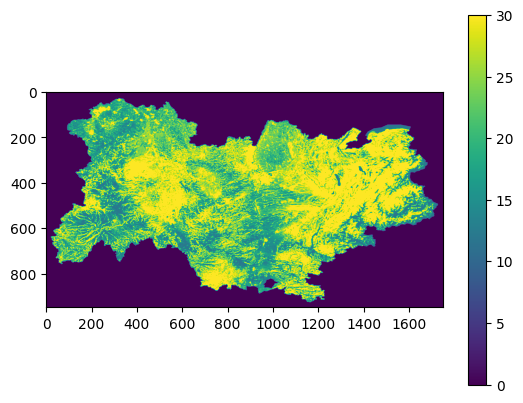

In [49]:
open_plot_tiff(path_new_cropped_tif)
